In [1]:
import numpy as np
import pandas as pd
import os
import random
import itertools
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy import stats
%matplotlib inline
import time
import datetime
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
%%time
# food price
price_food = pd.read_csv("/Users/yownho/GoogleDrive/DataIncubator_challange/Data/wfpvam_foodprices.csv")
# Population
population = pd.read_csv(
    "/Users/yownho/GoogleDrive/DataIncubator_challange/Data/Population-Estimates_CSV/Population-EstimatesData.csv")
# Temperature
temp = pd.read_csv(
    "/Users/yownho/GoogleDrive/DataIncubator_challange/Data/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCountry.csv")
# Conflict
conflict = pd.read_excel("/Users/yownho/GoogleDrive/DataIncubator_challange/Data/discon_1.0.xlsx")

CPU times: user 4.1 s, sys: 358 ms, total: 4.46 s
Wall time: 4.48 s


In [3]:
price_food.head()
price_food.shape

(964488, 18)

In [4]:
temp.head()
temp.shape

(577462, 4)

In [5]:
population.head()
population.shape

(45325, 96)

In [6]:
conflict.head()
conflict.shape

(6315, 18)

In [7]:
# extract year info
temp['year'] = pd.DatetimeIndex(temp['dt']).year

In [8]:
#year_max = price_food.loc[price_food['mp_year'].max()]
year_max_food = price_food['mp_year'].max()
year_min_food = price_food['mp_year'].min()

year_max_temp = temp['year'].max()
year_min_temp = temp['year'].min()

print("Food price: Max year is {} and min year is {}".format(year_max_food,year_min_food))
print("Temp: Max year is {} and min year is {}".format(year_max_temp,year_min_temp))

Food price: Max year is 2019 and min year is 1992
Temp: Max year is 2013 and min year is 1743


In [9]:
# list countries
countries_food = price_food.adm0_name.unique()
countries_conf = conflict.country.unique()

countries = np.intersect1d(countries_conf,countries_food)
print(countries)

['Bangladesh' u'Bhutan' u'Cambodia' 'Indonesia' u'Kyrgyzstan' u'Myanmar'
 'Nepal' u'Pakistan' 'Philippines' u'Sri Lanka' 'Tajikistan']


In [10]:
# drop Nepal and Kyrgyzstan
countries_ana = np.delete(countries,[4,5,6])

In [11]:
analysis_df = pd.DataFrame()
column = ['Country','Year','FoodPrice', 'Temp','Population','ConflictPeople']
for country in countries_ana:
    print(country)
    # food price
    food_cntry = price_food[price_food.adm0_name == country]
    # temperature
    temp_cntry = temp[temp.Country == country]
    # population
    ppltn_cntry = population[population[population.columns[0]] == country]
    ttl_ppltn_cntry = ppltn_cntry[ppltn_cntry[ppltn_cntry.columns[2]] == "Population, total"]
    # conflict
    conf_country = conflict[conflict.country == country]
    for yr in range(1992,2013+1):
        # food price
        food_cntry_year = food_cntry[food_cntry.mp_year == yr]
        foodprice_mean = food_cntry_year.mp_price.mean()
        # temperature
        temp_cntry_year = temp_cntry[temp_cntry.year == yr]
        tempcntry_mean = temp_cntry_year.AverageTemperature.mean()
        # population
        colnum = ttl_ppltn_cntry.columns.get_loc(str(yr))
        ttl_ppltn_cntry_yr = ttl_ppltn_cntry.iloc[:,colnum+1]
        ttl_ppl= ttl_ppltn_cntry_yr.iloc[0]
        # conflict
        conf_cntry_year = conf_country[conf_country.year == yr]
        confppl_ttl = conf_cntry_year.personnel.sum()
        # combine
        out_df = pd.DataFrame([[country,yr,foodprice_mean,tempcntry_mean,ttl_ppl,confppl_ttl]],columns=column)
        #print(out_df)
        analysis_df = analysis_df.append(out_df)

Bangladesh
Bhutan
Cambodia
Indonesia
Pakistan
Philippines
Sri Lanka
Tajikistan


Bangladesh
Bhutan
Cambodia
Indonesia
Pakistan
Philippines
Sri Lanka
Tajikistan


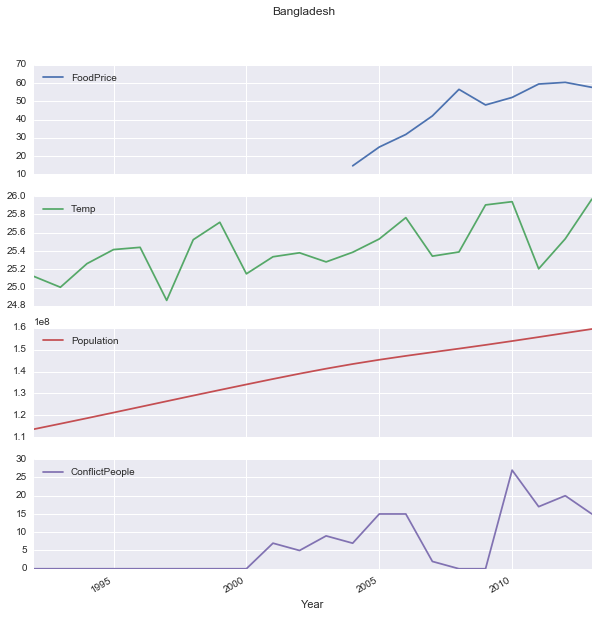

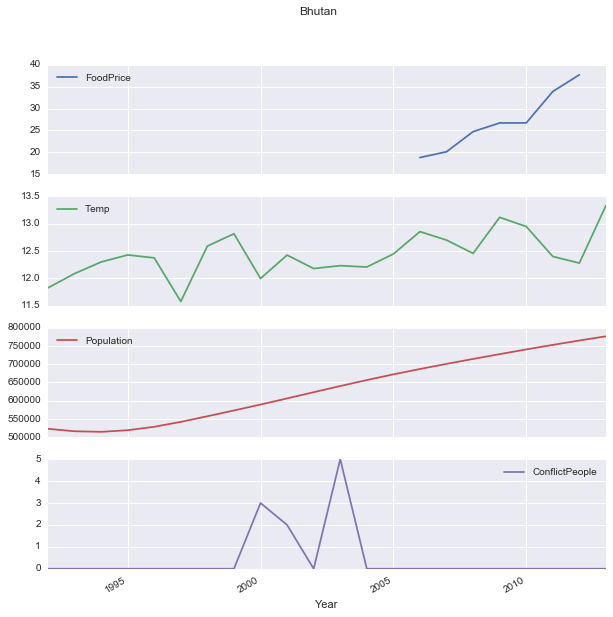

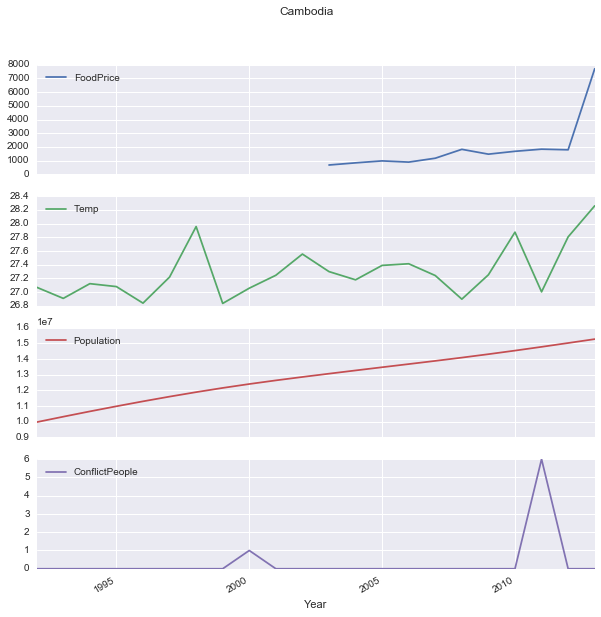

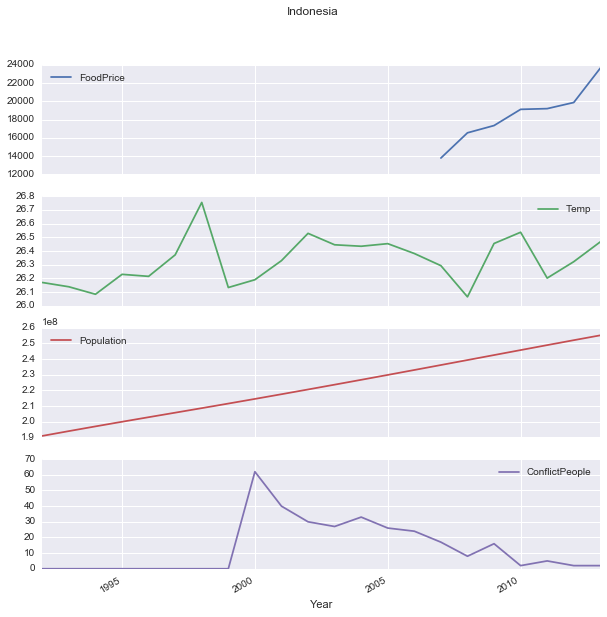

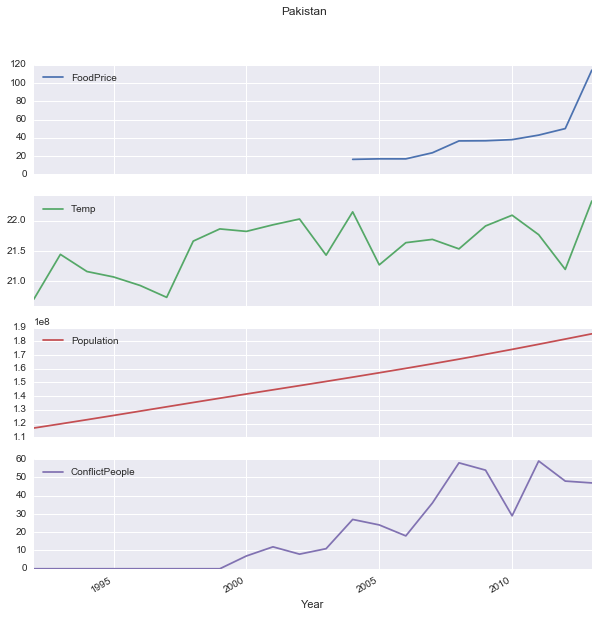

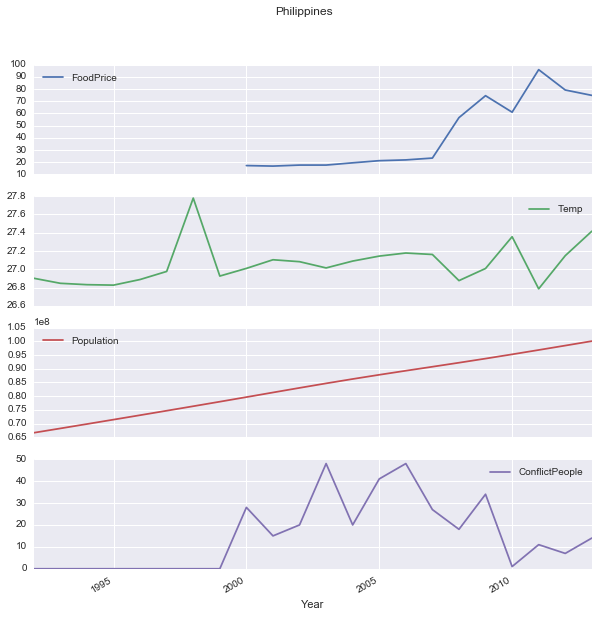

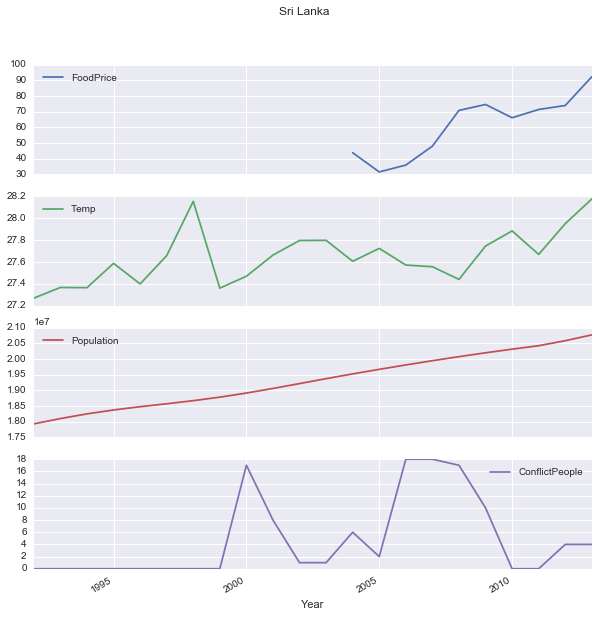

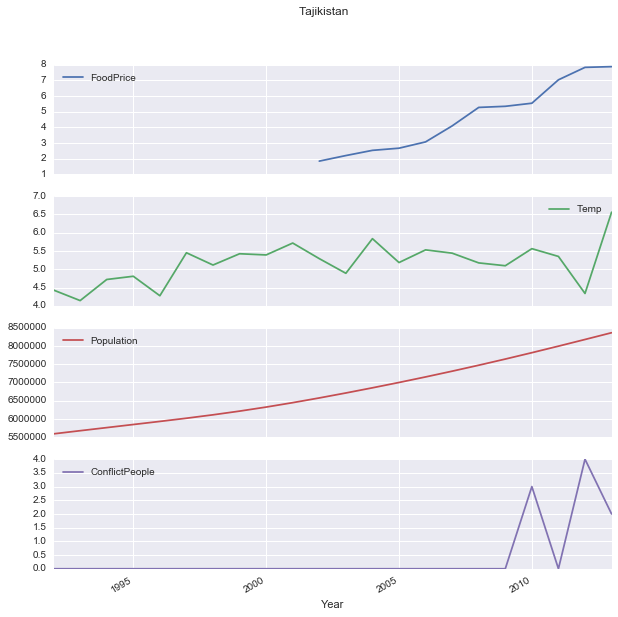

In [12]:
# make plot
for name_cuntry in countries_ana:
    print name_cuntry
    cntry_ana = analysis_df[analysis_df.Country == name_cuntry]
    cntry_ana.set_index('Year',inplace=True)
    FP_plot = cntry_ana.plot(subplots=True, title =name_cuntry, figsize=(10, 10)); 

In [13]:
# a simple linear regression analysis
for name_cuntry in countries_ana:
    print(name_cuntry)
    #name_cuntry = countries_ana[0]
    cntry_ana = analysis_df[analysis_df.Country == name_cuntry]
    cntry_ana.set_index('Year',inplace=True)
    cntry_ana = cntry_ana.dropna(axis=0)
    
    #split dataset
    feature_cols = ['Temp', 'Population', 'ConflictPeople']
    others_x = cntry_ana[feature_cols] # Features
    fp_y = cntry_ana.FoodPrice # Target variable
    #fp_y=fp_y.astype('int')

    # linear
    logit_model=sm.OLS(fp_y,others_x)
    result=logit_model.fit()
    print(result.summary())

Bangladesh
                            OLS Regression Results                            
Dep. Variable:              FoodPrice   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     157.7
Date:                Mon, 04 Feb 2019   Prob (F-statistic):           8.67e-07
Time:                        12:50:17   Log-Likelihood:                -31.604
No. Observations:                  10   AIC:                             69.21
Df Residuals:                       7   BIC:                             70.11
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Temp             -16.0872      2.